In [2]:
import numpy as np
import math
import re
import json
import gzip

In [3]:
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz

--2021-09-18 10:27:54--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 495854086 (473M) [application/x-gzip]
Saving to: ‘reviews_Electronics_5.json.gz’

reviews_Electronics 100%[===================>] 472.88M  5.40MB/s    in 1m 59s  

2021-09-18 10:29:53 (3.98 MB/s) - ‘reviews_Electronics_5.json.gz’ saved [495854086/495854086]



In [4]:
# Reading the data
json_content = []
file = 'reviews_Electronics_5.json.gz'
with gzip.open(file , 'rb') as gzip_file:
    for line in gzip_file:

        line = line.rstrip()  # removing xtra spaces
        if line:
            obj = json.loads(line)
            json_content.append(obj['reviewText'])
            
            if len(json_content) == 50000:
                break


In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
# sentences = array of sentence
from nltk.tokenize import sent_tokenize, word_tokenize

sentences = []
for i in json_content:
    sentences += sent_tokenize(i)

print(sentences[0])
# print(word_tokenize(sentences[1][0]))

We got this GPS for my husband who is an (OTR) over the road trucker.


In [7]:
# removing punctuation
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

# words = array of words
words = []
for i in sentences:
    words.append("<S>")
    words += tokenizer.tokenize(i.lower())  # lowercase words
    # words.append("<E>")

print(words[:25])

['<S>', 'we', 'got', 'this', 'gps', 'for', 'my', 'husband', 'who', 'is', 'an', 'otr', 'over', 'the', 'road', 'trucker', '<S>', 'very', 'impressed', 'with', 'the', 'shipping', 'time', 'it', 'arrived']


In [8]:
from collections import defaultdict

freq = defaultdict(int)
for i in words:
  freq[i]+=1

# removing words freq < 5
new_words = [i for i in words if freq[i] > 5]

print(new_words[:25])

['<S>', 'we', 'got', 'this', 'gps', 'for', 'my', 'husband', 'who', 'is', 'an', 'over', 'the', 'road', 'trucker', '<S>', 'very', 'impressed', 'with', 'the', 'shipping', 'time', 'it', 'arrived', 'a']


In [9]:
# word2ind & ind2word
word2ind=defaultdict(list)
ind2word=defaultdict(list)

c = 0
# giving each word its index
for i in freq:
  if freq[i] > 5:
    ind2word[c]=i
    word2ind[i]=c
    c+=1

# print(freq[new_words[word2ind["<E>"]]])
# print(new_words[word2ind["<E>"]])

In [10]:
# constructing co-occurrence matrix
import scipy
from scipy import sparse
from scipy.sparse import lil_matrix

window_size = 3
matrix = sparse.lil_matrix((len(ind2word),len(ind2word)))

for i in range(1,len(new_words)):
  if new_words[i] == "<S>":
    continue
  curr_word = new_words[i]
  for j in range(1,window_size+1):
    if i-j < 0 or new_words[i-j] == "<S>":
      break
    
    context_word = new_words[i-j]
    matrix[word2ind[curr_word], word2ind[context_word]]+=1

matrix = matrix+matrix.transpose()

In [11]:
print(matrix[word2ind["we"],word2ind["got"]])
print(matrix[word2ind["got"],word2ind["we"]])

119.0
119.0


In [12]:
# Applying svd
from scipy.sparse.linalg import svds
U,S,VT = svds(matrix,k=100)

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

# returns top10 nearest neighbours to 'str' string
def top10(str):
  array = []
  v1 = U[word2ind[str]]
  for i in range (0,len(U)):
    # angle = cosine_similarity(v1, U[i])
    angle = np.dot(v1,U[i])/(np.linalg.norm(v1)*np.linalg.norm(U[i]))
    array.append([angle,ind2word[i]])
  
  array.sort(reverse=True)
  return array[:10]

# print(top10("camera"))  

# print(top10("good"))  
# print(top10("device"))  
# print(top10("terrible"))  
# print(top10("hard"))  
print(top10("awesome"))  

[[1.0, 'awesome'], [0.969866732943653, 'amazing'], [0.956987277811541, 'incredible'], [0.9010620172791565, 'outstanding'], [0.8853923002042687, 'excellent'], [0.8622324013014105, 'exceptional'], [0.8138512755727285, 'absolute'], [0.8009949151665617, 'astonishing'], [0.7944746055890968, 'insane'], [0.7852796069344561, 'unbelievable']]


In [14]:
# Mounting gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import pickle

# storing embeddings
embedding = [i for i in U]
file = open("./drive/MyDrive/NLP/q1/embed.pkl","wb")
pickle.dump(embedding,file)
file.close()

# storing trained model
# 1. storing ind2word
embedding = [i for i in ind2word]
file = open("./drive/MyDrive/NLP/q1/ind2word.pkl","wb")
pickle.dump(embedding,file)
file.close()

# 2. storing word2ind
embedding = [i for i in word2ind]
file = open("./drive/MyDrive/NLP/q1/word2ind.pkl","wb")
pickle.dump(embedding,file)
file.close()

In [16]:
# gensim
# Find closest to 'camera'

# from gensim.models import Word2Vec
# model = Word2Vec(new_words,min_count=1,size=100)

# model.most_similar("camera")[:10]

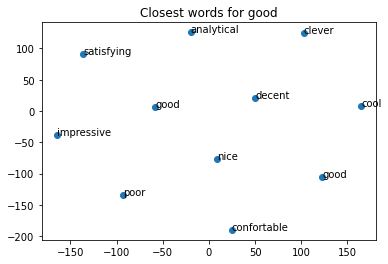

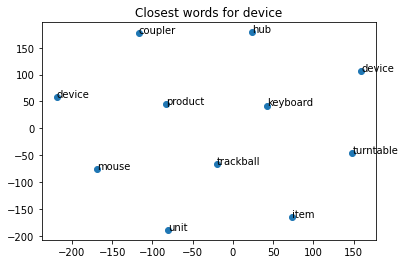

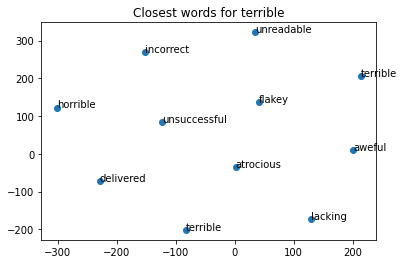

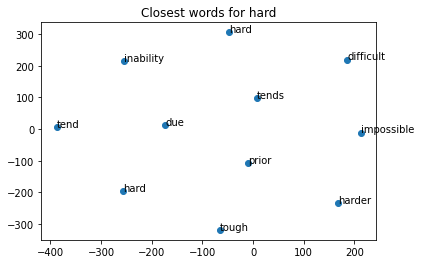

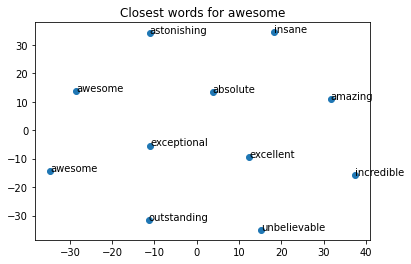

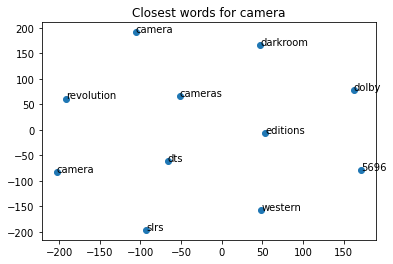

In [22]:
# plotting graphs
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

list_of_closest_words = {
    "good": ["good", "poor", "decent", "nice", "analytical", "confortable", "cool", "satisfying", "clever", "impressive"],
    "device": ["device", "mouse", "unit", "turntable", "item", "keyboard", "trackball", "product", "hub", "coupler"],
    "terrible": ["terrible", "horrible", "aweful", "atrocious", "lacking", "unsuccessful", "unreadable", "flakey", "incorrect", "delivered"],
    "hard": ["hard", "harder", "difficult", "tough", "impossible", "due", "prior", "tends", "inability", "tend"],
    "awesome": ["awesome", "amazing", "incredible", "outstanding", "excellent", "exceptional", "absolute", "astonishing", "insane", "unbelievable"],
    "camera": ["camera", "western", "5696", "editions", "cameras", "dolby", "dts", "slrs", "darkroom", "revolution"]
}

global_embeddings = []
global_annotations = []
for w in list_of_closest_words:

    tsne = TSNE(n_components=2)

    w_embeddings = [U[word2ind[w]]]
    w_embeddings += [U[word2ind[cw]] for cw in list_of_closest_words[w]]
    global_embeddings += w_embeddings

    annotations = [w]
    annotations += [cw for cw in list_of_closest_words[w]]
    global_annotations += annotations

    flattened_embeddings = tsne.fit_transform(w_embeddings)

    X_coordinates = flattened_embeddings[:,0].tolist()
    Y_coordinates = flattened_embeddings[:,1].tolist()

    plt.figure()
    plt.title(f"Closest words for {w}")
    plt.scatter(X_coordinates, Y_coordinates)

    for w_no, annotation in enumerate(annotations):
        plt.annotate(annotation, (X_coordinates[w_no], Y_coordinates[w_no]))

    plt.savefig(f"./drive/MyDrive/NLP/q1/{w}.png")